## Time Series Regression Analysis at Corporation Favorita

### Business Understanding
### Problem Statement:
Corporation Favorita aims to improve inventory management by accurately forecasting product demand across its stores in Ecuador. This project focuses on developing robust time series regression models using historical sales data, promotional activities, and store-specific attributes to optimize inventory levels, reduce stockouts, and enhance operational efficiency

### Project Description:
In this project, we aim to develop robust machine learning models to forecast the unit sales of various items across Corporation Favorita's stores in Ecuador. Leveraging the CRISP-DM framework, our goal is to accurately predict future sales based on historical data, store locations, product attributes, promotional activities, and other relevant factors. By doing so, we intend to optimize inventory management and ensure that each store maintains sufficient stock levels to meet customer demand effectively.

### Hypothesis Testing :
- Null Hypothesis (H0): Historical sales data, promotional indicators, and store-specific characteristics have no significant impact on the accuracy of sales forecasts for individual items across Corporation Favorita's stores.

- Alternative Hypothesis (H1): By utilizing historical sales data, promotional indicators, and store-specific characteristics, we can build predictive models that significantly improve the accuracy of sales forecasts for individual items across Corporation Favorita's stores.

### Analytical Questions:
- Is the train dataset complete (has all the required dates)?
- Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
- Compare the sales for each month across the years and determine which month of which year had the highest sales.
- Did the earthquake impact sales?
- Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
- Are sales affected by promotions, oil prices and holidays?
- What analysis can we get from the date and its extractable features?
- Which product family and stores did the promotions affect.
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
- Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

### Data Understanding

In [2]:
# Import necessary libraries

# Connect to server
import pyodbc
from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns


# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
#from pmdarima.arima import CHTest, nsdiffs
from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from a .env file
env_variables = dotenv_values(r'C:\Users\MERCY CHEBET\Desktop\Azubi\Time-Series-Forecasting-Analysis\.env')

server= env_variables.get('SERVER')
database= env_variables.get('DATABASE')
username= env_variables.get('USERNAME')
password= env_variables.get('PASSWORD')

In [4]:
# Setup connection string to connect to the remote server
connection_string =pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')

In [5]:
# Query statement to fetch oil, holidays_events and stores data from the remote server
oil_query = 'SELECT * FROM dbo.oil'
holidays_query = 'SELECT * FROM dbo.holidays_events'
stores_query = 'SELECT * FROM dbo.stores'

In [6]:
# Redefine datatypes
dtypes = {'id':'int64', 'store_nbr':'int8', 'onpromotion': str}

In [8]:
# Connecting to the Dataset
# Read all data from different sources
data_oil = pd.read_sql_query(oil_query, connection_string, parse_dates=['date'])
df_holidays_events = pd.read_sql_query(holidays_query, connection_string, parse_dates=['date'], dtype={'transferred': str})
df_stores = pd.read_sql_query(stores_query, connection_string)
transactions = pd.read_csv('..\\datasets\\transactions.csv', parse_dates=['date'])
df_train = pd.read_csv('..\\datasets\\train.csv', parse_dates=['date'], dtype=dtypes)
df_test = pd.read_csv('..\\datasets\\test.csv', parse_dates=['date'], dtype=dtypes)

##### Inspecting Columns In Oil

In [9]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [10]:
data_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [11]:
data_oil.shape

(1218, 2)

In [12]:
data_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [13]:
data_oil.duplicated().sum()

np.int64(0)

##### Inspecting Columns In Holiday

In [14]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [15]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 16.5+ KB


In [16]:
df_holidays_events.shape

(350, 6)

In [17]:
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [18]:
df_holidays_events.duplicated().sum()

np.int64(0)

##### Inspecting Columns In Stores

In [19]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [21]:
df_stores.shape

(54, 5)

In [22]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [23]:

df_stores.duplicated().sum()

np.int64(0)

##### Checking Unique Values

In [24]:
def print_unique_values(df, df_name):
    columns = df.columns
    print(f'Unique values in {df_name}:')
    for column in columns:
        print(f'{column}')
        unique_values = df[column].unique()
        print(f'There are {unique_values.size} unique values')
        print(f'{unique_values}')
        print('=' * 50)
    print('\n')

# Check unique values in df_stores
print_unique_values(df_stores, 'df_stores')

# Check unique values in df_holidays_events
print_unique_values(df_holidays_events, 'df_holidays_events')

# Check unique values in data_oil
print_unique_values(data_oil, 'data_oil')

Unique values in df_stores:
store_nbr
There are 54 unique values
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
city
There are 22 unique values
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
state
There are 16 unique values
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
type
There are 5 unique values
['D' 'B' 'C' 'E' 'A']
cluster
There are 17 unique values
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


Unique values in df_holidays_events:
date
There are 312 unique values
<DatetimeArray>
['2012-03-02 00:00:00', '2012-04-01 00:00:00', '20

#### UNIVARIATE ANALYSIS

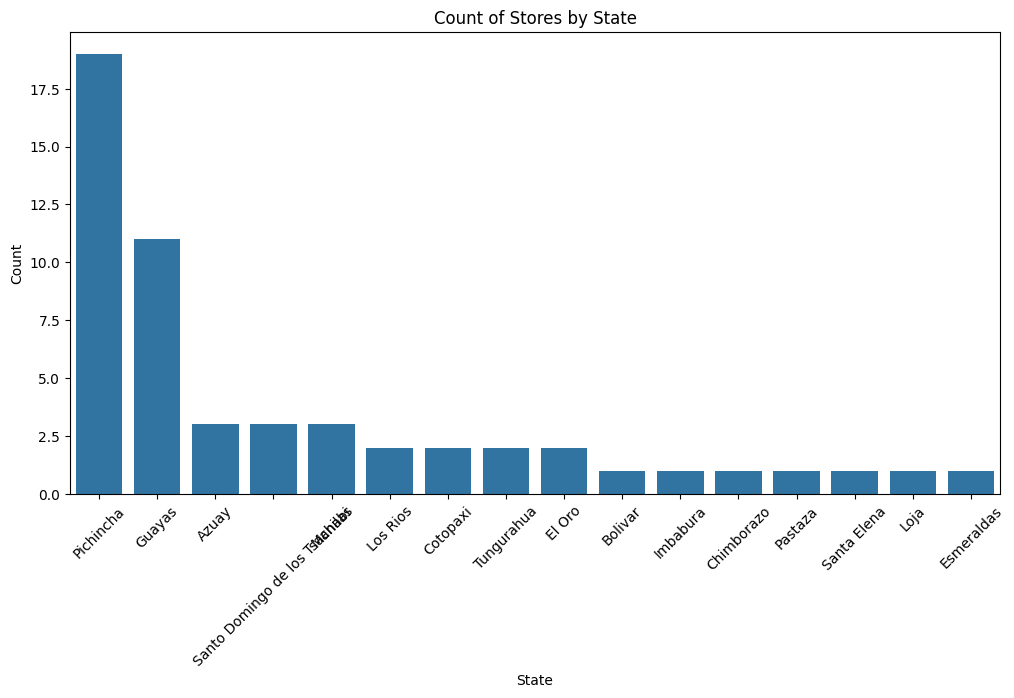

In [25]:
# Count of stores by state
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=df_stores, order=df_stores['state'].value_counts().index)
plt.title('Count of Stores by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

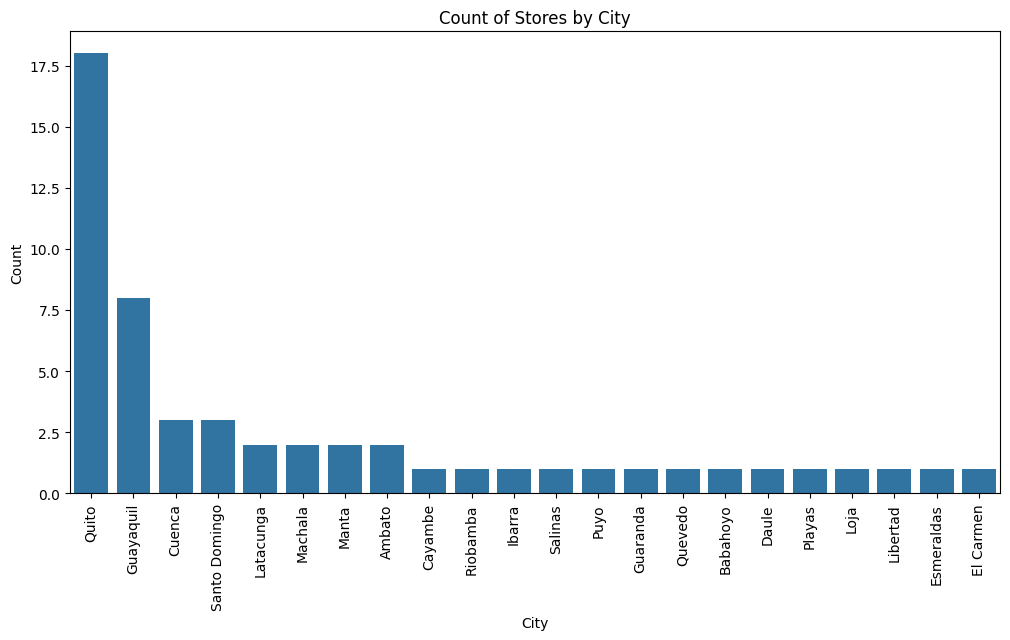

In [26]:
# Count of stores by city
plt.figure(figsize=(12, 6))
sns.countplot(x='city', data=df_stores, order=df_stores['city'].value_counts().index)
plt.title('Count of Stores by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()